<a href="https://colab.research.google.com/github/matibag1714977/LabiagiProject/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Progetto-Scene Classification**

Import

In [4]:
import numpy as np      #to perform mathematical operations on arrays and matrices
import matplotlib.pyplot as plt  #to visualize images and plot graphs

#provides algoithms and tools for data analysis and modeling(classification,regression,clustering)
from sklearn.model_selection import train_test_split        
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

#It provides a user-friendly interface for building and training deep learning models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

# It provides various tools and functions for image and video processing, including image filtering, feature detection, and object tracking.
import cv2
import imghdr
import os
import tensorflow as tf


from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model


import torch
import torchvision
import torchvision.transforms as transforms

import splitfolders



Import dataset Prova

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

folder_id = '1pFM_HpOjh0qbAadk0-1Fz89mwLHrnQHB?usp=share_link'
data_path = '/content/gdrive/MyDrive/Dataset/input_data'


# mount the folder
drive.mount('/content/gdrive', force_remount=True)




Mounted at /content/gdrive
Mounted at /content/gdrive


Per dividere la cartella training,testing validation

In [6]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
input_folder ="/content/gdrive/MyDrive/Dataset/input_data"
output="/content/gdrive/MyDrive/Dataset/processed_data"
splitfolders.ratio(input_folder,output,seed=42,ratio=(.6, .2, .2))

Copying files: 6660 files [30:15,  3.67 files/s]


In [8]:
img_height, img_width = (224,224)
batch_size=32

train_data_dir=f"/content/gdrive/MyDrive/Dataset/processed_data/train"
valid_data_dir=f"/content/gdrive/MyDrive/Dataset/processed_data/val"
test_data_dir=f"/content/gdrive/MyDrive/Dataset/processed_data/test"

Generate batches of tensor image data with real-time data augmentation.

In [25]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical")

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode="categorical")



Found 3991 images belonging to 10 classes.
Found 1327 images belonging to 10 classes.
Found 1342 images belonging to 10 classes.


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

# definisci la trasformazione per ridimensionare le immagini

In [38]:
transform = transforms.Compose(
    [transforms.Resize((256, 256)),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Carica il tuo dataset utilizzando ImageFolder e preparo il  dataset per l'addestramento

In [45]:

train_dataset = datasets.ImageFolder(root='/content/gdrive/MyDrive/Dataset/processed_data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/gdrive/MyDrive/Dataset/processed_data/test', transform=transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Carica il modello ResNet50

In [46]:

model = models.resnet50(pretrained=False)

# Definisci il numero di classi
num_classes = len(train_dataset.classes)

# Modifica l'ultimo layer del modello per adattarlo al numero di classi
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Zero grad
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass e aggiornamento dei pesi
        loss.backward()
        optimizer.step()
    
    # Valuta il modello sul dataset di test
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print('Accuracy of the model on the test images: {:.2f}%'.format(accuracy))

In [10]:
EPOCHS = 100



base_model = ResNet50(include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)

predictions = Dense(train_generator.num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"])




history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=EPOCHS)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.3993 - acc: 0.8928

KeyboardInterrupt: ignored

Mostra alcune immagini

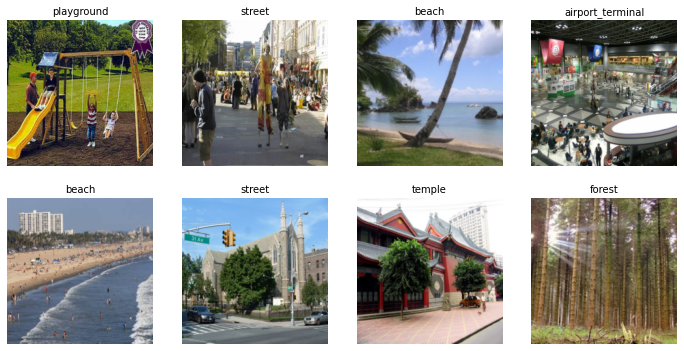

In [26]:
import random
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

# Target image size
image_size = (224, 224)

# Path to the main SUN397 dataset directory
dataset_path = "/content/gdrive/MyDrive/Dataset/input_data"

# Transformation pipeline to preprocess the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the ImageFolder dataset
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)

# List of the 10 classes to display
classes_to_display = ["beach", "temple", "forest", "mountain", "airport_terminal", "river", "street", "playground", "skyscraper","bridge"]

# Select 8 random images from the dataset
random_images = random.sample(dataset.imgs, 8)

# Plot the selected images along with their class name
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    img_path, label = random_images[i]
    class_name = dataset.classes[label]
    if class_name in classes_to_display:
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        img = img.permute(1, 2, 0).numpy() # Convert from Tensor to numpy array and permute dimensions
        img = (img * 0.5) + 0.5 # Reverse the normalization
        img = Image.fromarray((img * 255).astype('uint8')) # Convert from numpy array to PIL Image
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(class_name, fontsize=10)

plt.show()


Normalizing